# Assignment: Shock-tube

### Load Modules

In [150]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

from matplotlib import animation
from JSAnimation.IPython_display import display_animation

### Setup parameters

In [151]:
# Construct grid
nx = 81
dx = 0.25
dt = 0.0002
T = 0.01
nt = int(T/dt)
gamma = 1.4
x_L = -10
x_R = 10

### Initial Condition

In [152]:
#Boundary conditions LEFT
rho_L = 1.
vel_L = 0.
pressure_L = 100. * 1000

#Boundary conditions RIGHT
rho_R = 0.125
vel_R = 0.
pressure_R = 10. * 1000

x=numpy.linspace(x_L,x_R,nx)

# Density
rho0=numpy.zeros(nx)
rho0[0:int((nx-1)/2)]=rho_L
rho0[int((nx-1)/2):nx]=rho_R

# Velocity
vel0=numpy.zeros(nx)
vel0[0:int((nx-1)/2)]=vel_L
vel0[int((nx-1)/2):nx]=vel_R

# pressure
pressure0=numpy.zeros(nx)
pressure0[0:int((nx-1)/2)]=pressure_L
pressure0[int((nx-1)/2):nx]=pressure_R

# energy
energy = pressure0 / ((gamma-1)*rho0)
energyT0=numpy.zeros(nx)
energyT0[0:int((nx-1)/2)]=(energy[0:int((nx-1)/2)] + 0.5*vel_L)
energyT0[int((nx-1)/2):nx]=(energy[int((nx-1)/2):nx] + 0.5*vel_R)


### Plot Initial Conditions

#### Density

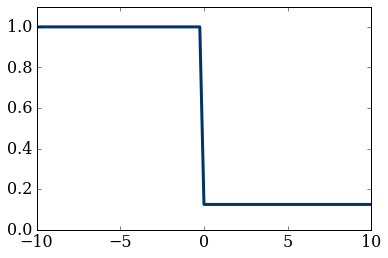

In [153]:
pyplot.plot(x, rho0, color='#003366', ls='-', lw=3)
pyplot.ylim(0.,1.1);

#### Pressure

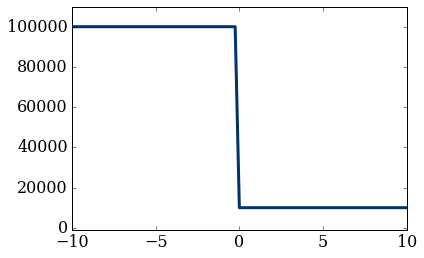

In [154]:
pyplot.plot(x, pressure0, color='#003366', ls='-', lw=3)
pyplot.ylim(-1000,110000);

#### Velocity

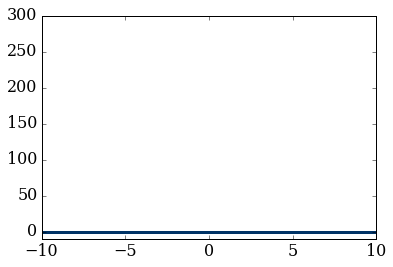

In [155]:
pyplot.plot(x, vel0, color='#003366', ls='-', lw=3)
pyplot.ylim(-10, 300);

#### Energy

(-200, 300000)

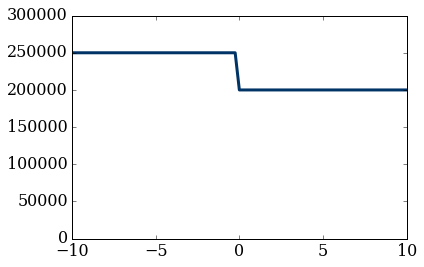

In [156]:
pyplot.plot(x, energyT0, color='#003366', ls='-', lw=3)
pyplot.ylim(-200, 300000)

### Define a function f() to match the right-hand side of our equations

In [161]:
def f(U,gamma):
    """Returns the right-hand side of the rocket system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    F : array of float
        array containing the RHS given u.
    """
    
    # Extract parameters from vector U
    u1 = U[0] # density
    u2 = U[1] # density * velocity
    u3 = U[2] # density * energyT
    u4 = U[3] # presure
    
    # cmpute pressure and energyT
    p = (gamma - 1) * (u3 - 0.5 * u2**2 / u1)
    e = u4 / ((gamma -1)*u1)
    eT = e + 0.5*u1**2
    vel = u2 / u1
    
    return numpy.array([ u2,
                       u2**2/u1 + p,
                       (u3 + p) * u2/u1,
                       p,
                       eT,
                       vel])

### Richtmyer Scheme 

In [193]:
def richtmyer_half(params, nt, dt, dx, gamma):
    """ Computes the solution with forward in time, backward in space
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    vel    : array of floats
            Velocity at current time-step    
    press  : array of floats
             Pressure
    energy:  array of flaots
              Energy
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    gamma: float
            Constant
    
    Returns
    -------
    U : array of floats
            solution grid after nt time steps at every point x
    """
    
    ### WITH HALF INDICES
    
    #Initialise grid
    U=numpy.zeros((nt, 6, len(params[0])))
    U[0, 0] = params[0]                 # rho      
    U[0, 1] = params[0] * params[1]     # rho * vel
    U[0, 2] = params[0] * params[3]     # rho * energyT 
    U[0, 3] = params[2]                 # pressure
    U[0, 4] = params[3]                 # energyT
    
    #initialize results array - must be same size as initial grid
    U_n = numpy.zeros((nt, 6, len(params[0]))) 
    #copy the initial u array into each row of our new array
    U_n = U.copy()    
    
    # Initialise arrays
    U_plus_half = numpy.empty_like(U[0])
    U_minus_half = numpy.empty_like(U[0])
    # copy initial conditions into U_t_Minus_1
    U_t_Minus_1 = U[0].copy()
        
    for t in range (1,nt):
        ### step 1
        ## Compute U_plus_half and U_minus_half

        U_plus_half = 0.5*(U_t_Minus_1[:,2:] + U_t_Minus_1[:,1:-1]) - \
                dt/2*dx * (f(U_t_Minus_1[:,2:], gamma)  - f(U_t_Minus_1[:,1:-1], gamma))
        
        U_minus_half = 0.5*(U_t_Minus_1[:,:-2] + U_t_Minus_1[:,1:-1]) - \
                dt/2*dx * (f(U_t_Minus_1[:,0:-2], gamma) - f(U_t_Minus_1[:,1:-1], gamma))     
        
        ### Step 2
        # Compute Solution for time t
        U_n[t,:,1:-1] = U_t_Minus_1[:,1:-1] - dt/dx * (f(U_plus_half, gamma) - \
                                                       f(U_minus_half, gamma))
        # re-set boundary conditions
        U_n[t,:,0] = U[0,:,0]
        U_n[t,:,-1] = U[0,:,-1]
        
        U_t_Minus_1 = U_n[t].copy()
    
    
    return U_n

### Simulation

In [194]:
params = [rho0, vel0, pressure0, energyT0]
# call Richtmyer scheme
#rU = richtmyer(params, nt, dt, dx, gamma)
# Richmyer scheme with half indices 
U = richtmyer_half(params, nt, dt, dx, gamma)
# MacCormack scheme
#mU = maccormack(params, nt, dt, dx, gamma)


# Retrieve variables
rho=U[:,0]
vel=U[:,5]
pressure = U[:,3]
energy=U[:,4]

#print(pressure[40])
#print(pressure[41])
#print(pressure[42])
#print(pressure[43])
#print(pressure[44])



/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: overflow encountered in multiply
/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in subtract
/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: overflow encountered in square
/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: overflow encountered in square
/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in add
/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in subtract
/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in subtract
/home/gavin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered i

### Animations

#### Density


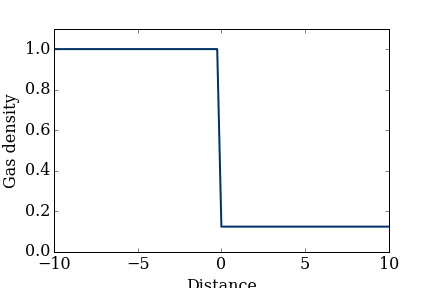
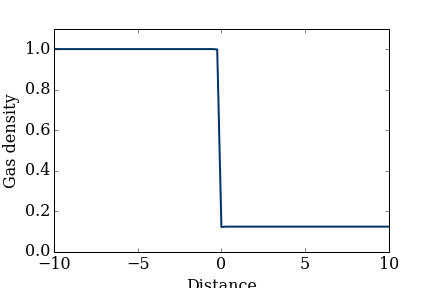
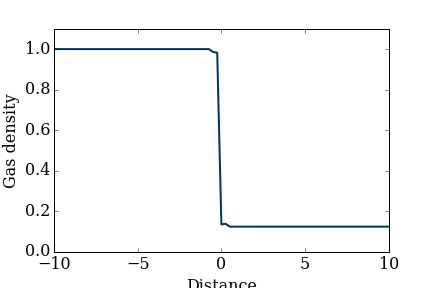
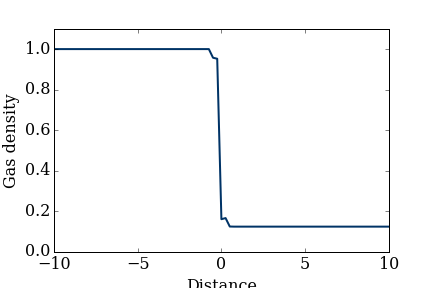
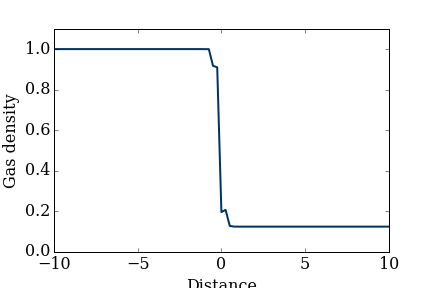
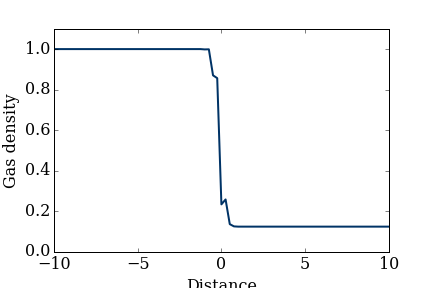
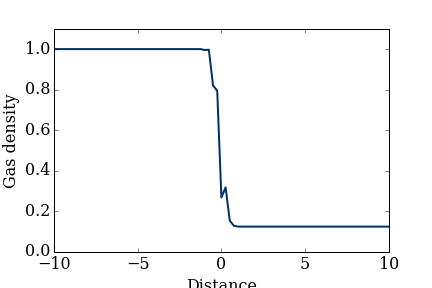
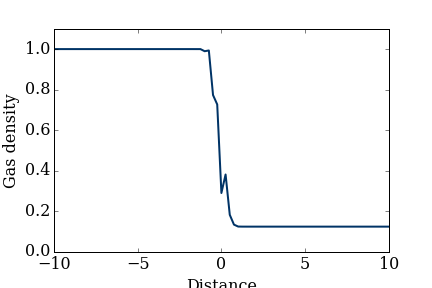
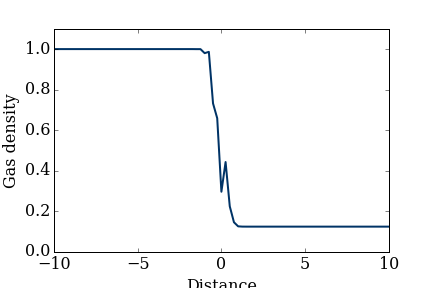
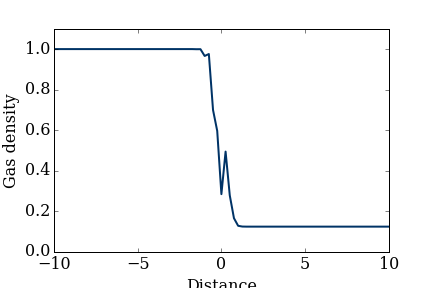
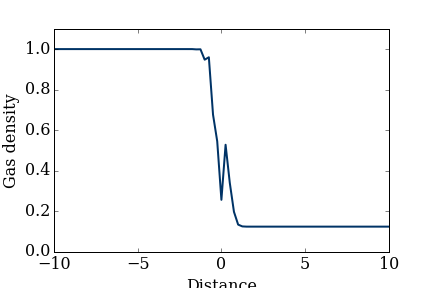
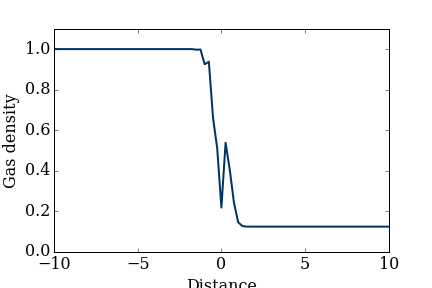
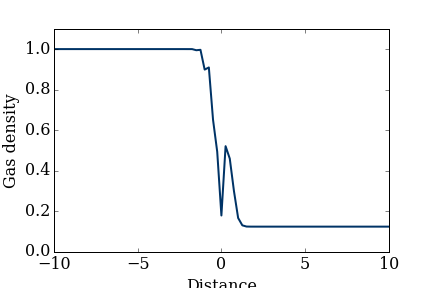
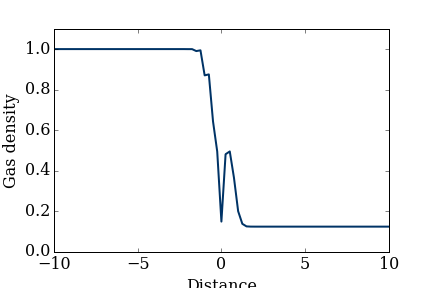
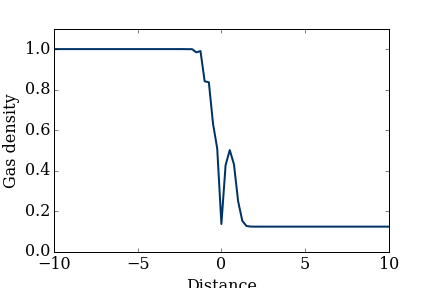
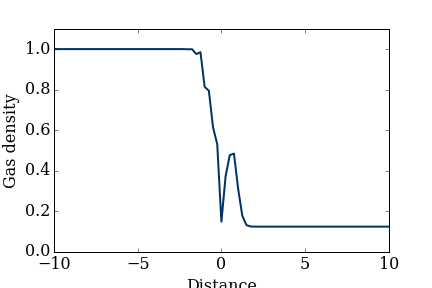
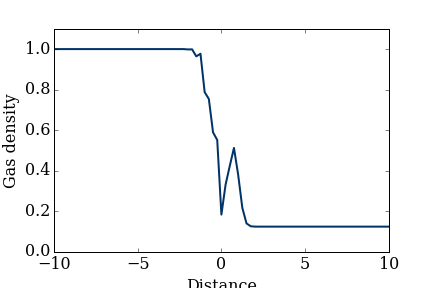
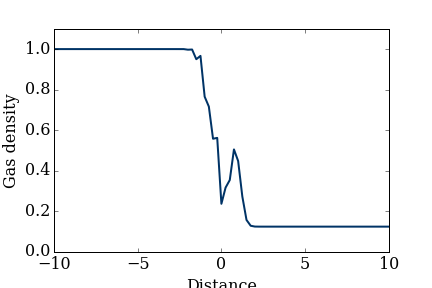
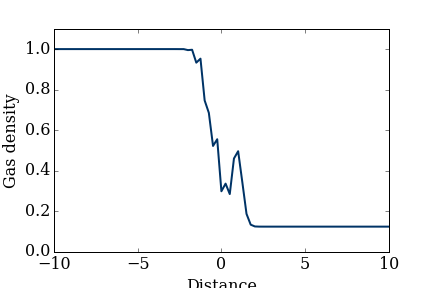
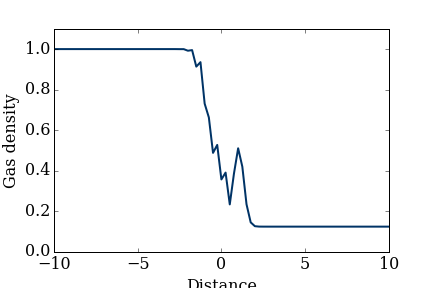
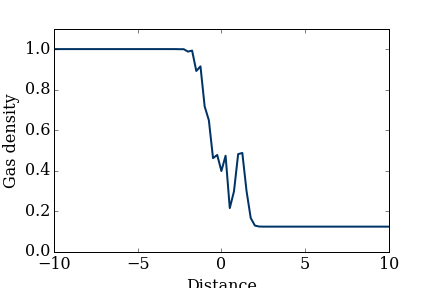
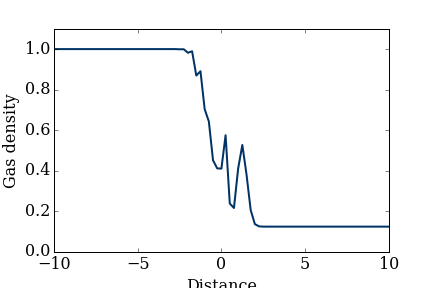
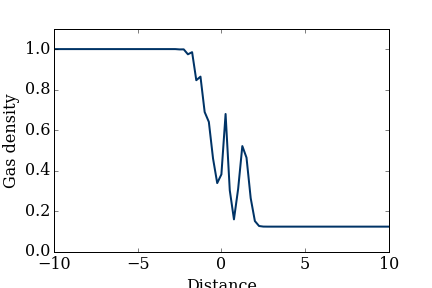
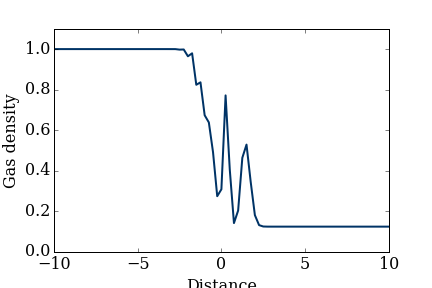
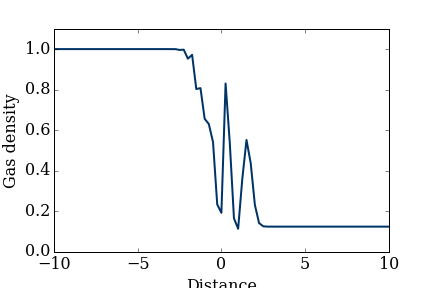
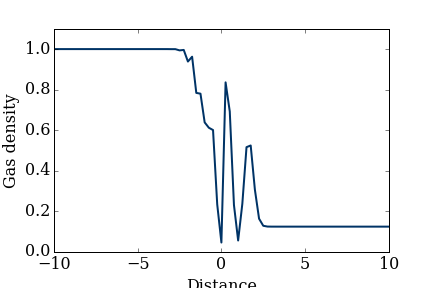
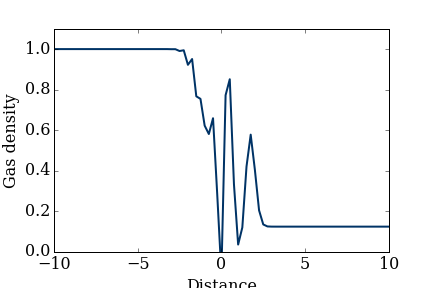
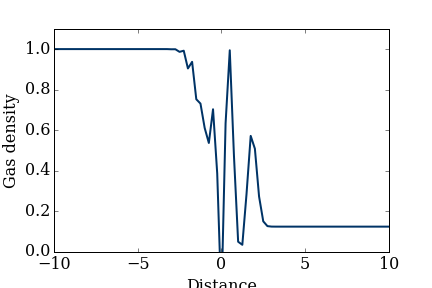
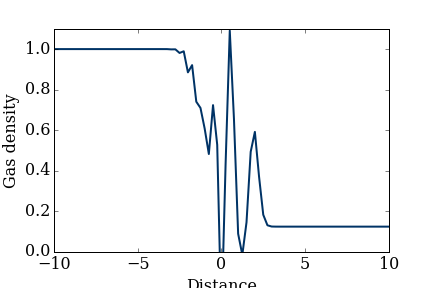
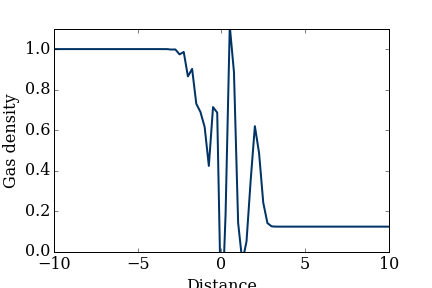
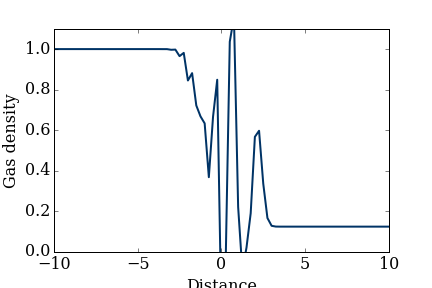
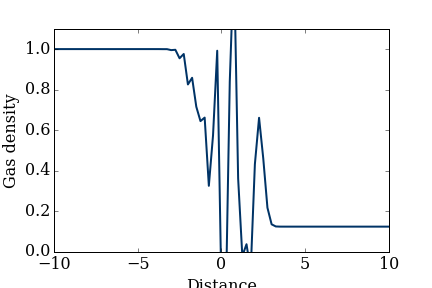
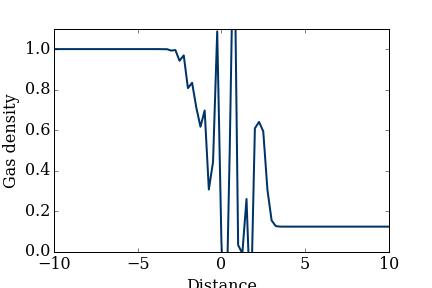
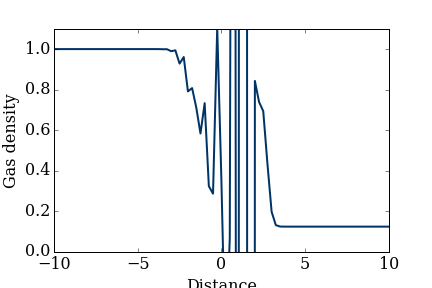
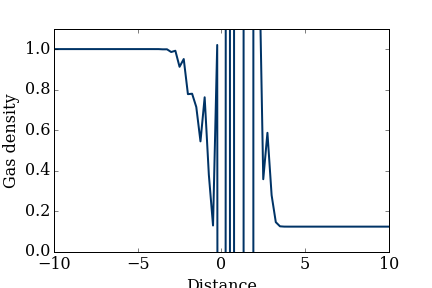
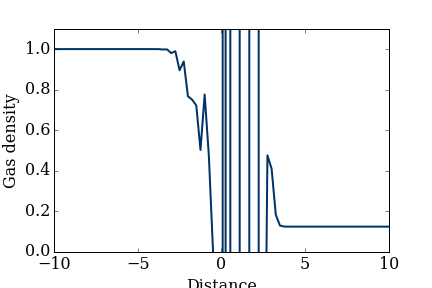
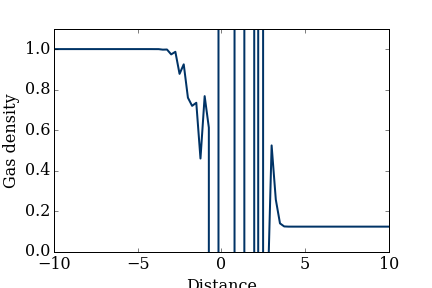
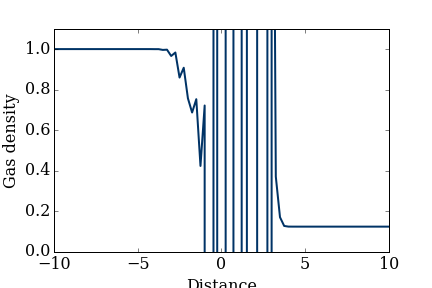
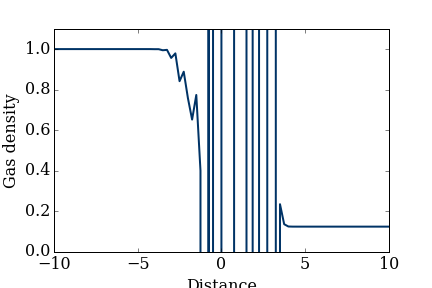
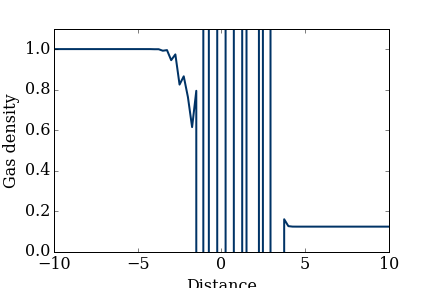
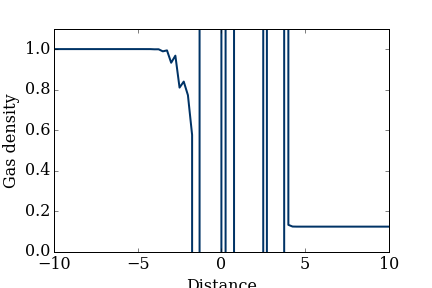
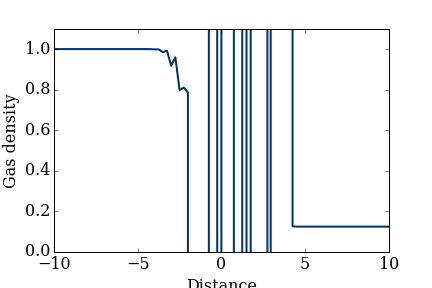
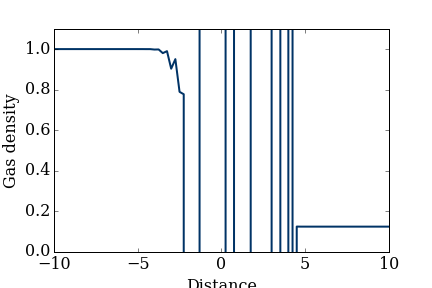
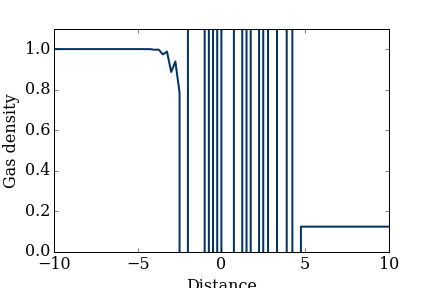
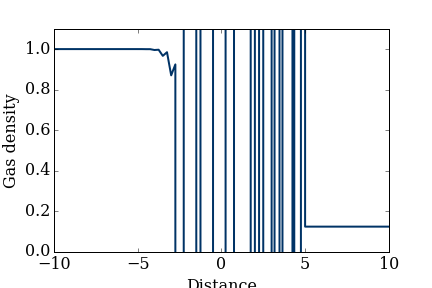
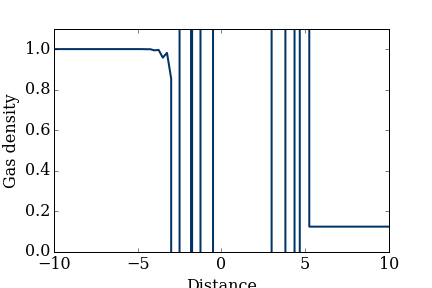
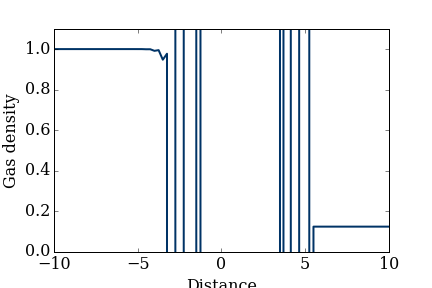
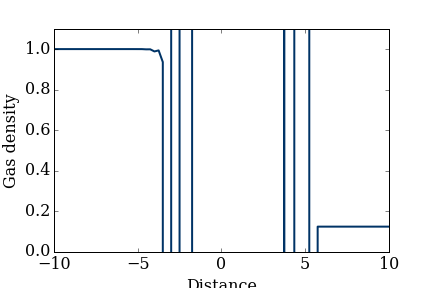
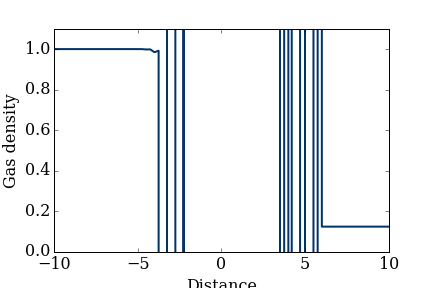
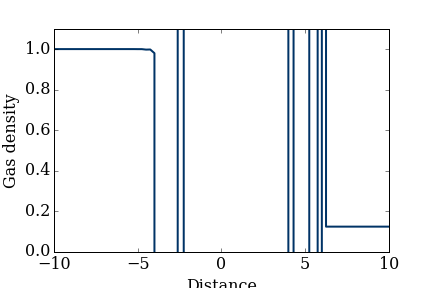

In [195]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=((x_L,x_R)),ylim=(0.,1.1),xlabel=('Distance'),ylabel=('Gas density'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(x_L,x_R,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=rho, interval=50)
display_animation(anim, default_mode='once')

#### Velocity


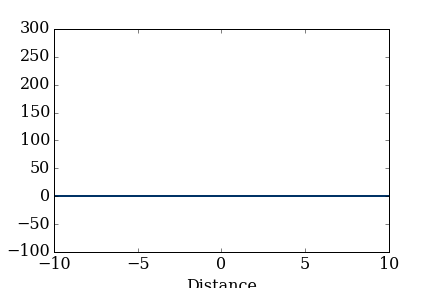
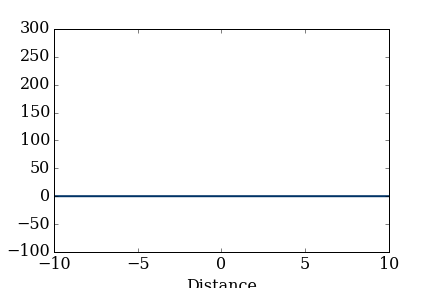
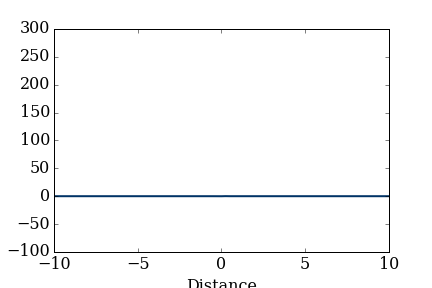
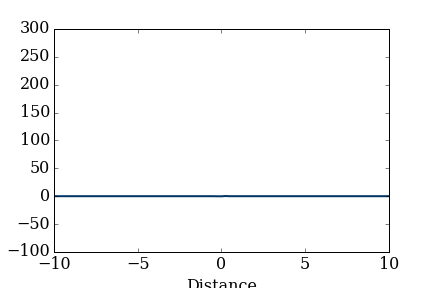
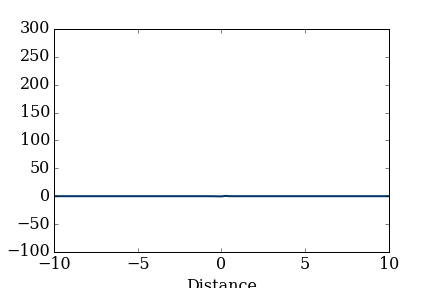
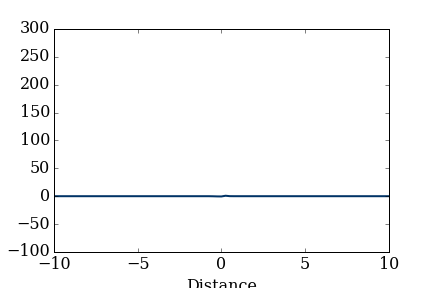
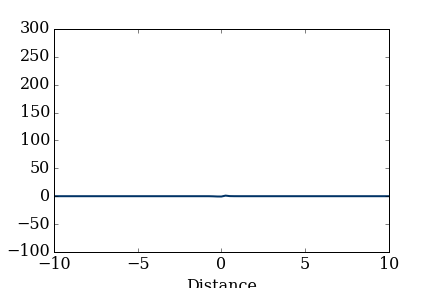
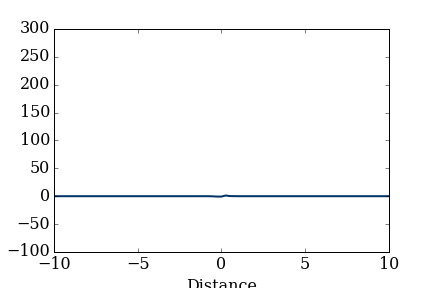
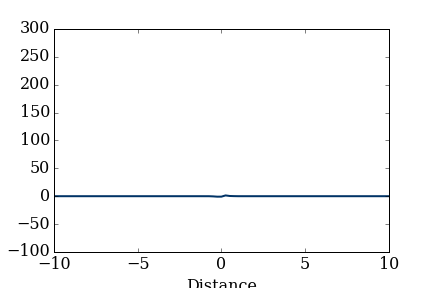
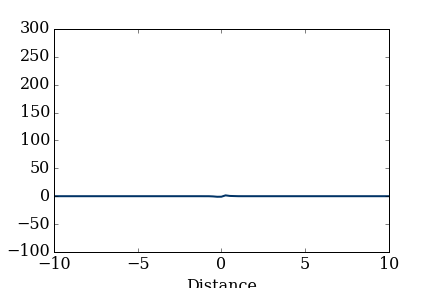
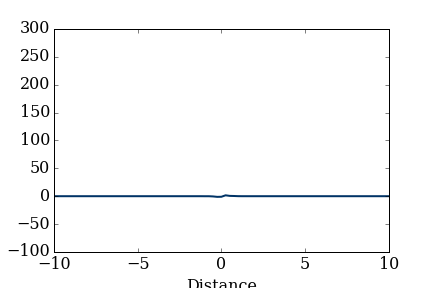
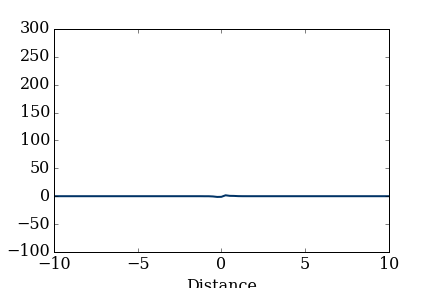
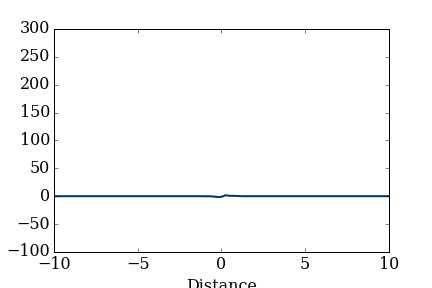
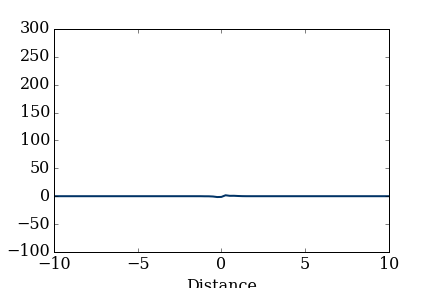
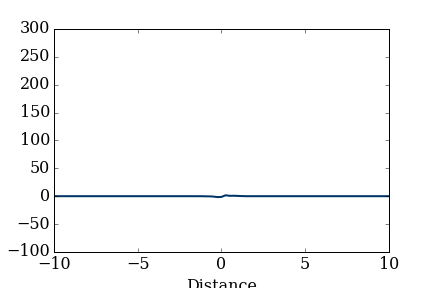
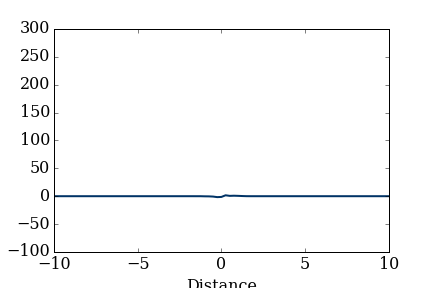
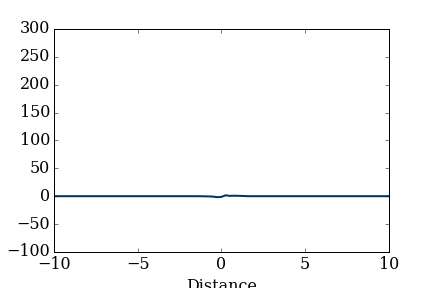
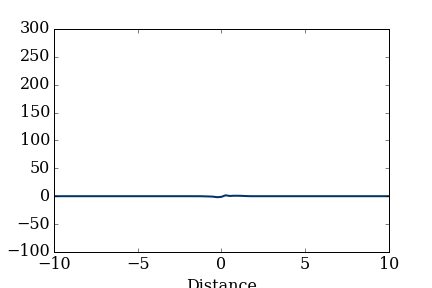
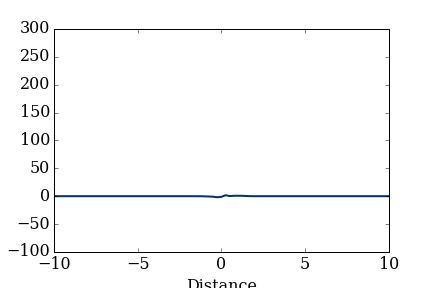
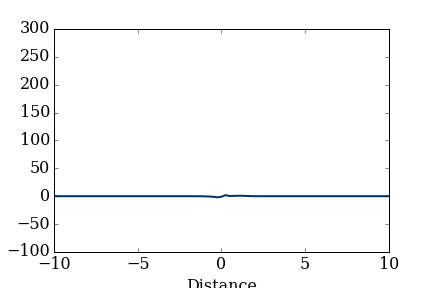
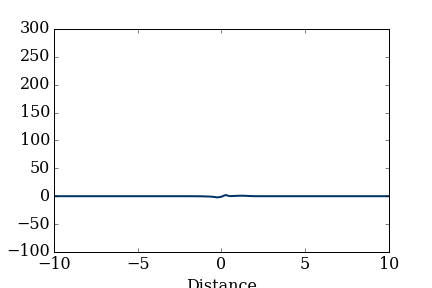
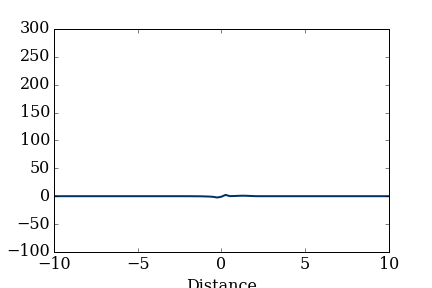
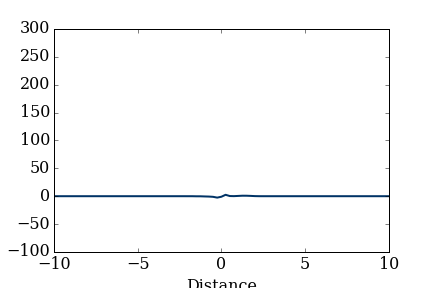
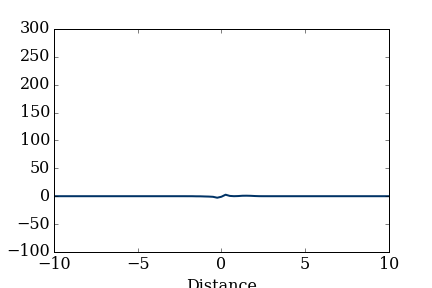
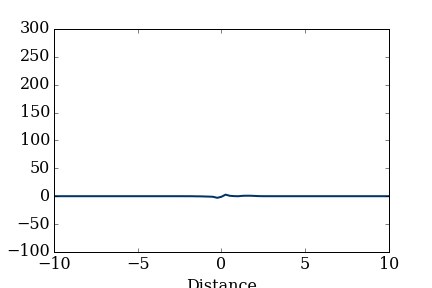
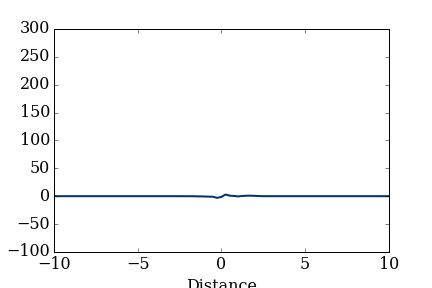
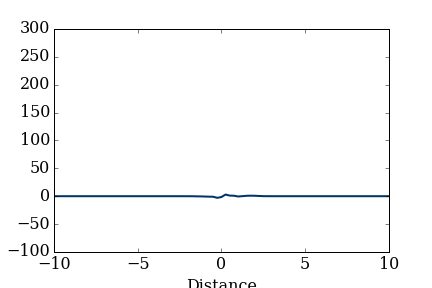
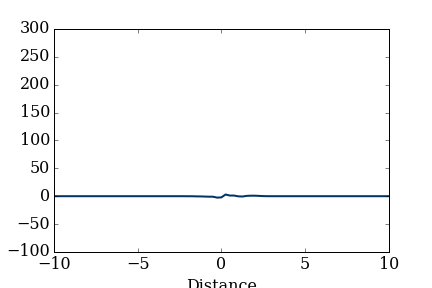
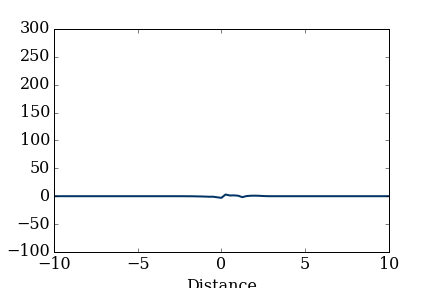
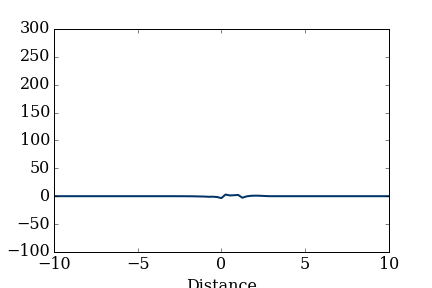
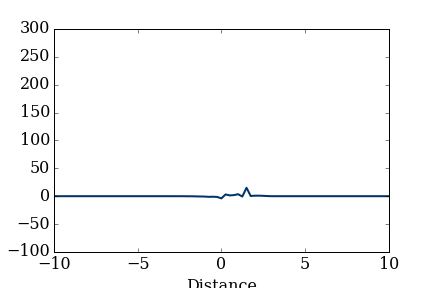
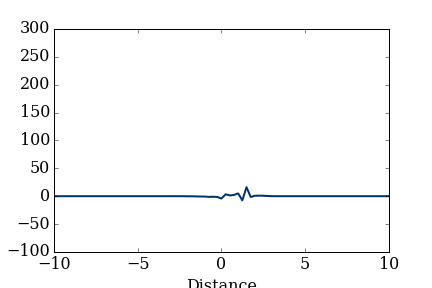
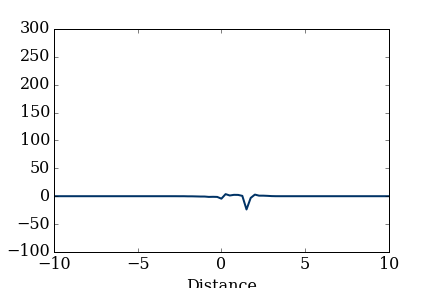
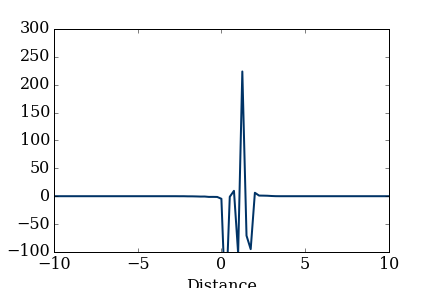
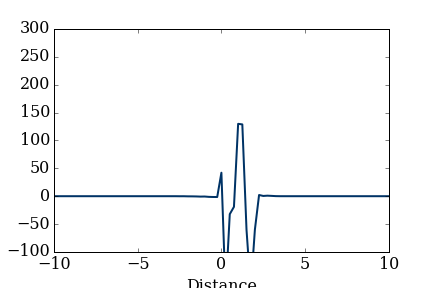
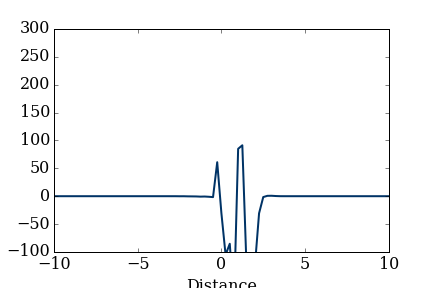
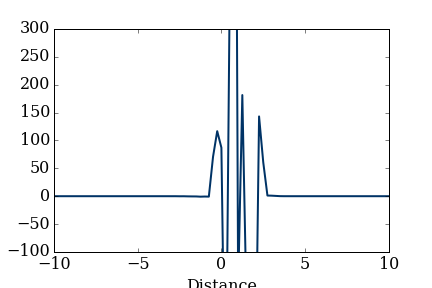
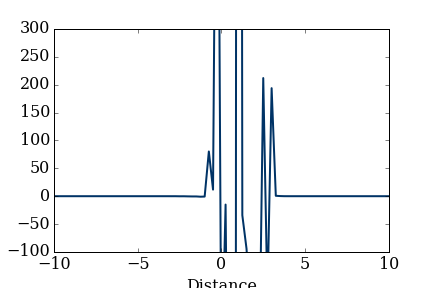
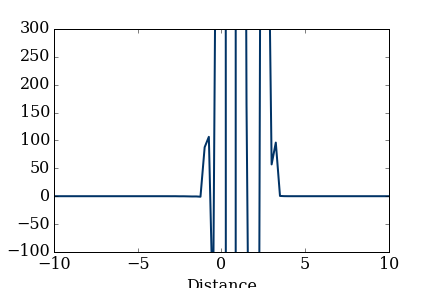
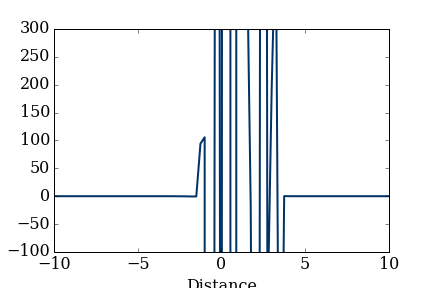
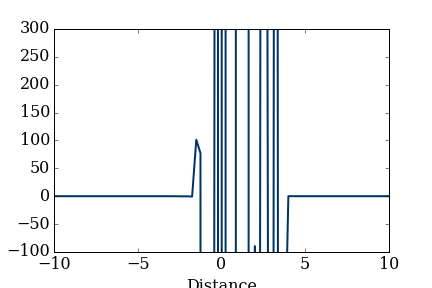
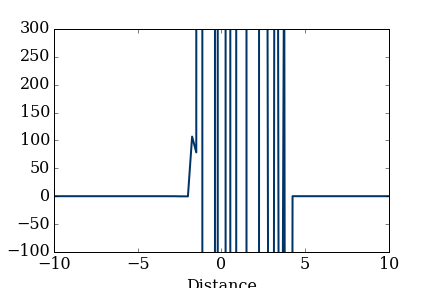
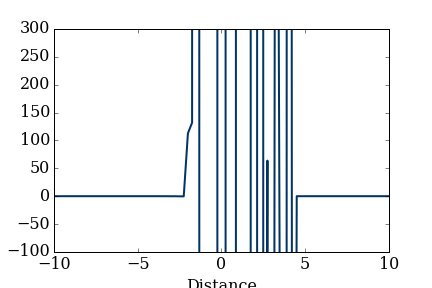
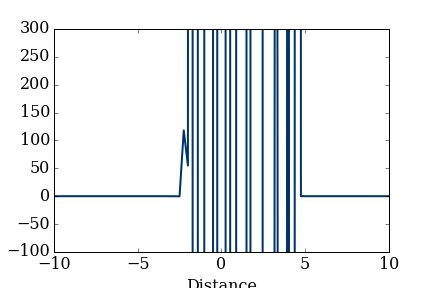
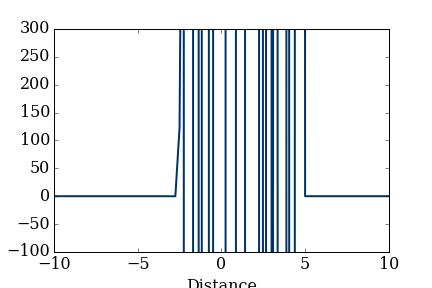
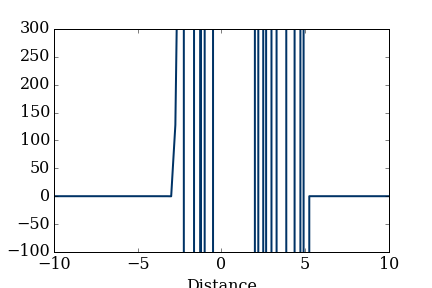
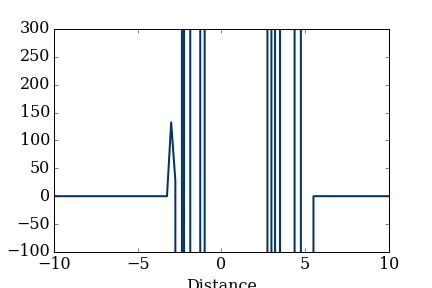
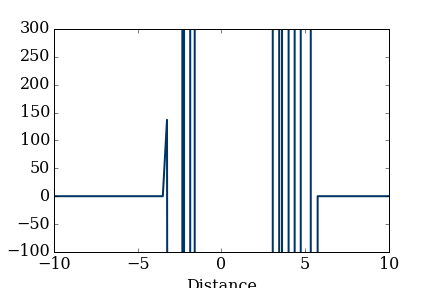
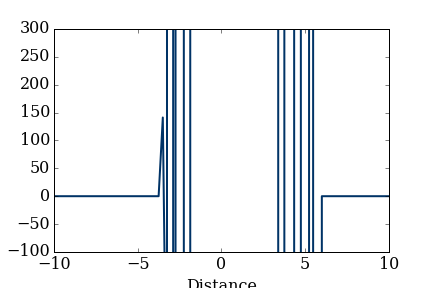
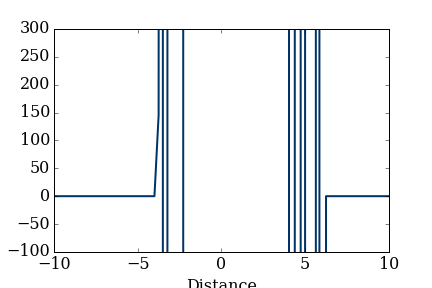

In [196]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=((x_L,x_R)),ylim=(-100, 300),xlabel=('Distance'),ylabel=('Gas velocity'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(x_L,x_R,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=vel, interval=50)
display_animation(anim, default_mode='once')

#### Pressure


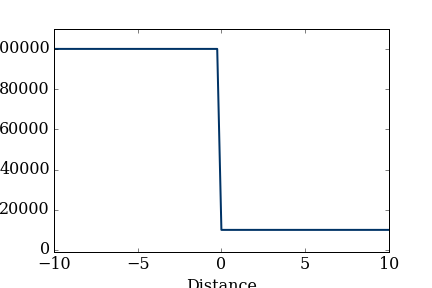
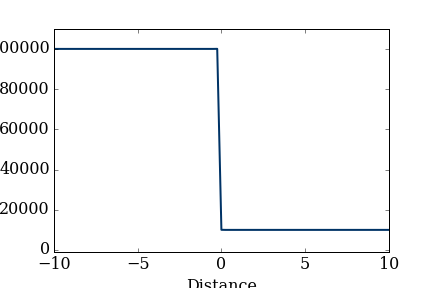
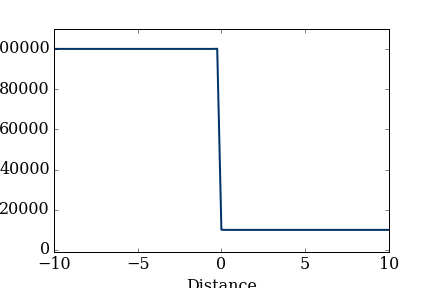
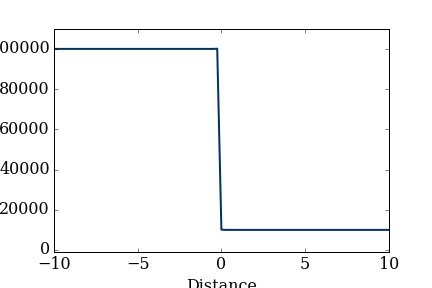
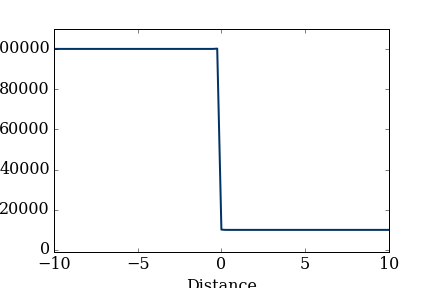
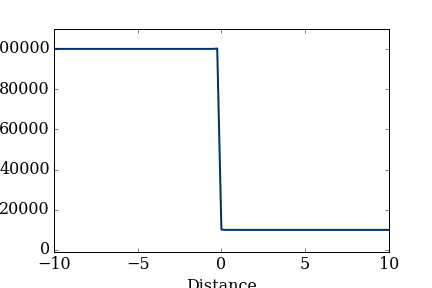
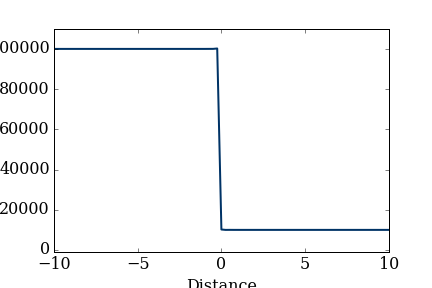
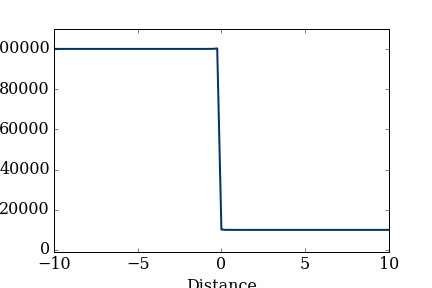
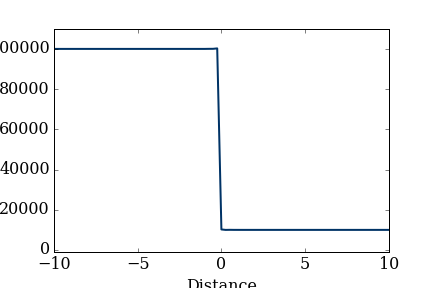
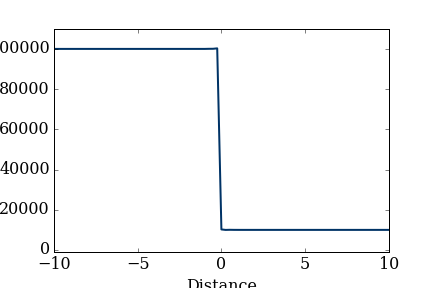
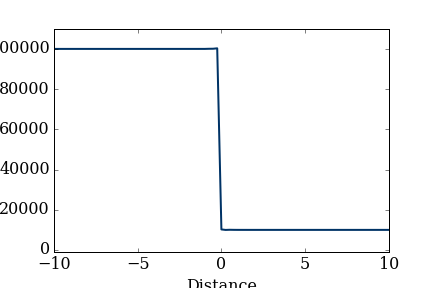
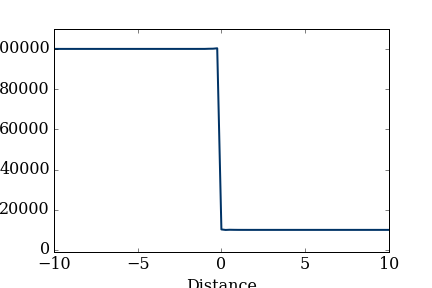
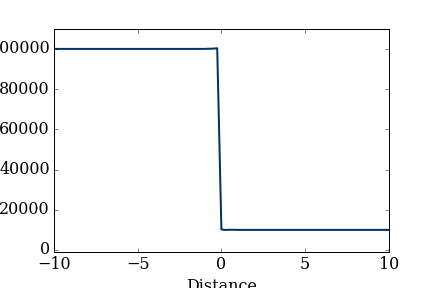
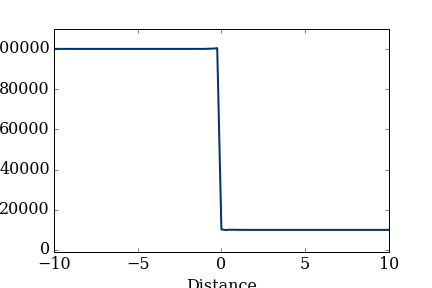
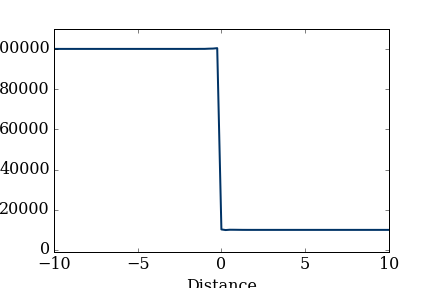
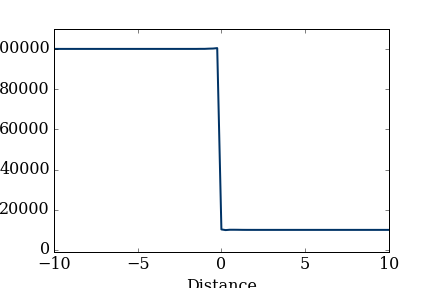
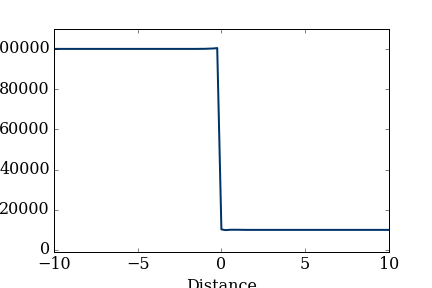
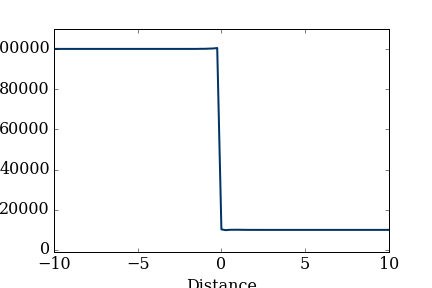
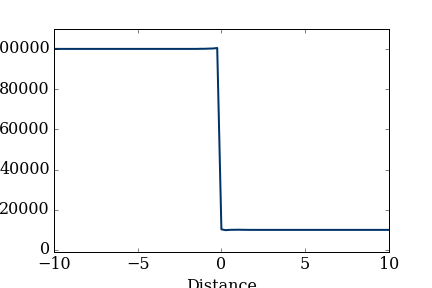
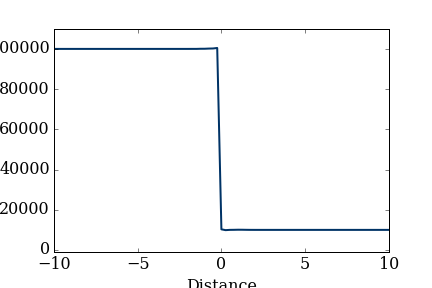
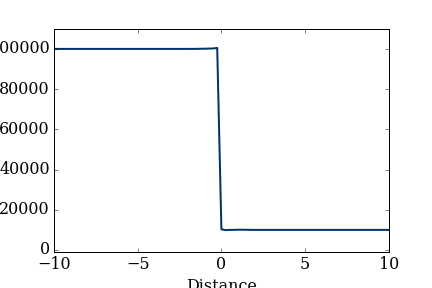
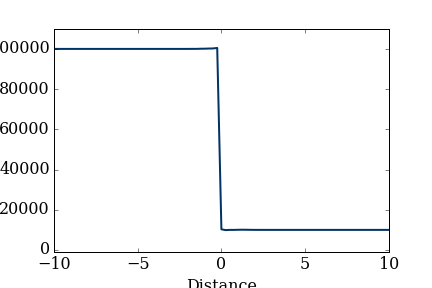
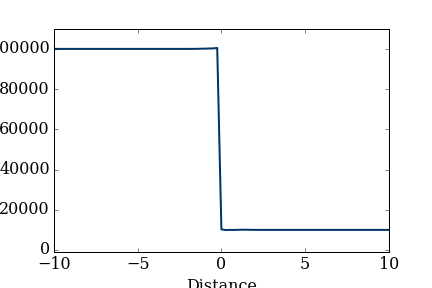
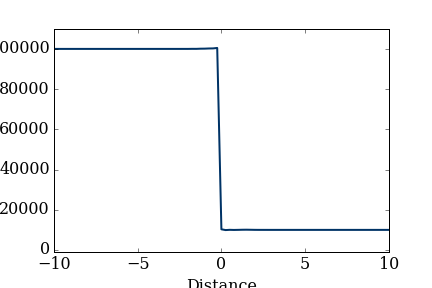
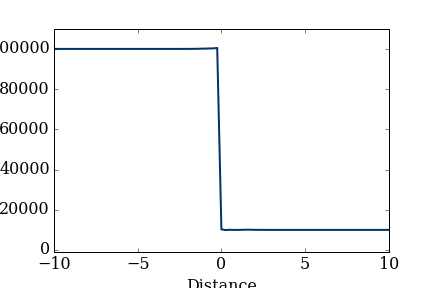
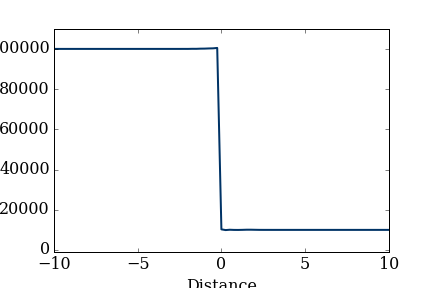
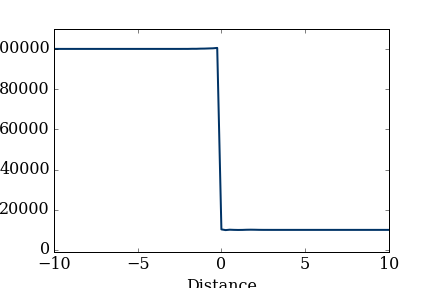
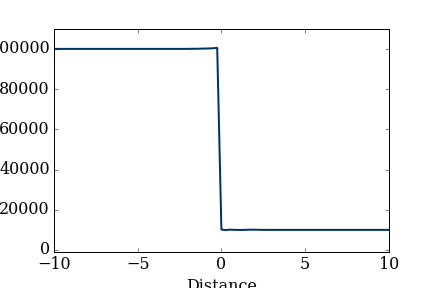
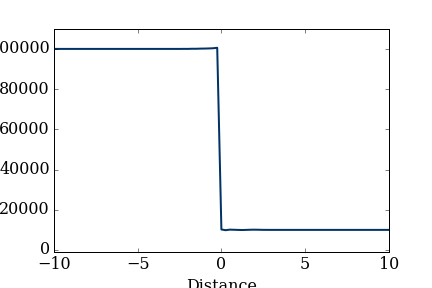
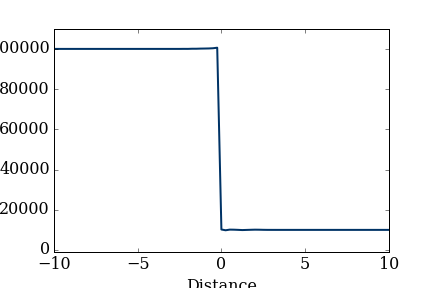
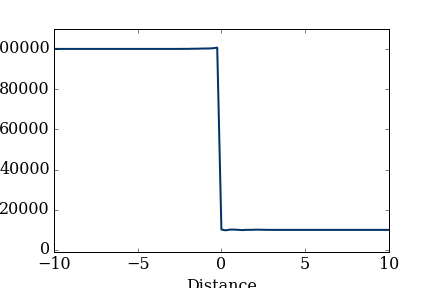
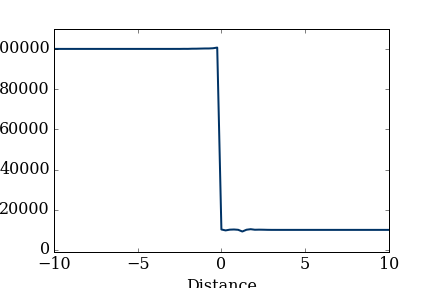
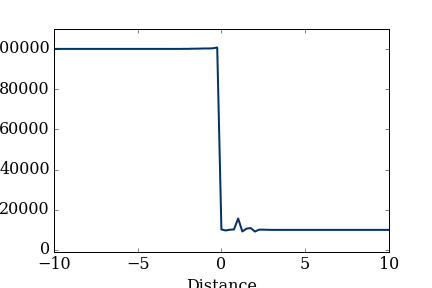
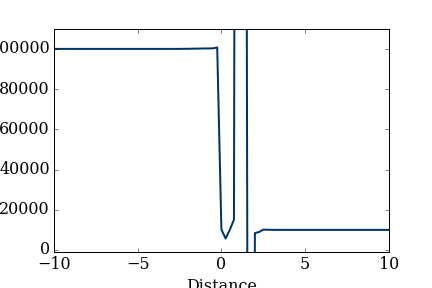
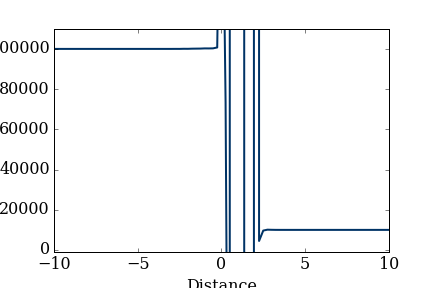
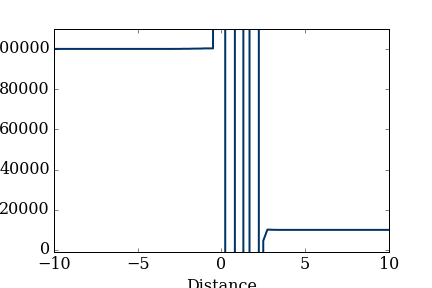
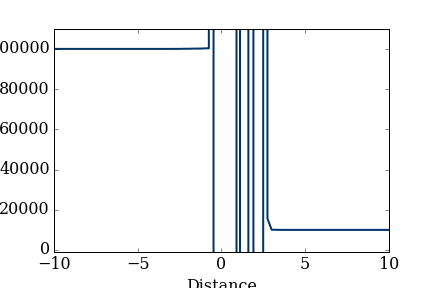
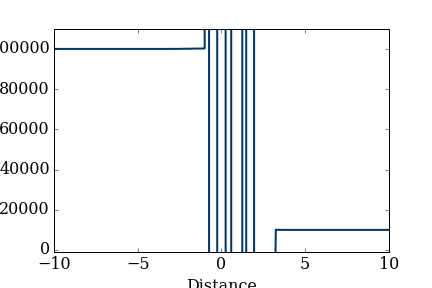
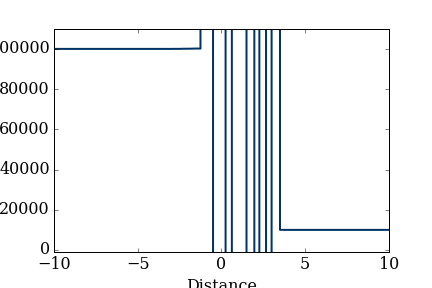
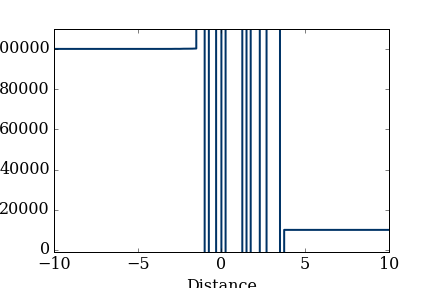
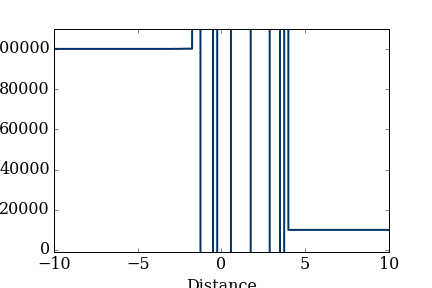
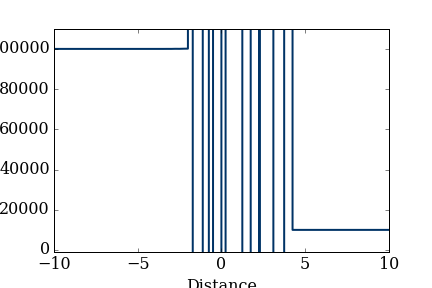
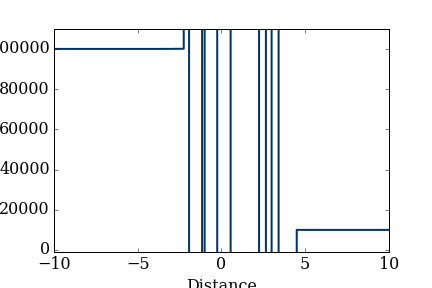
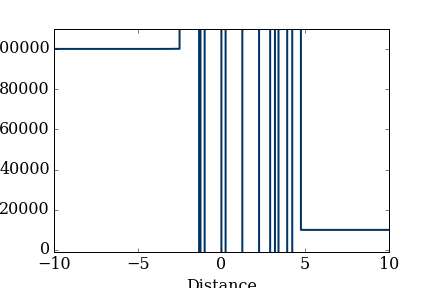
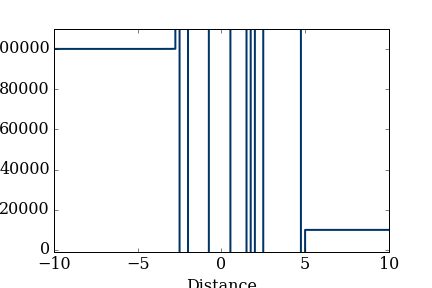
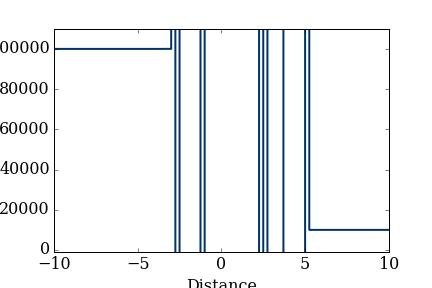
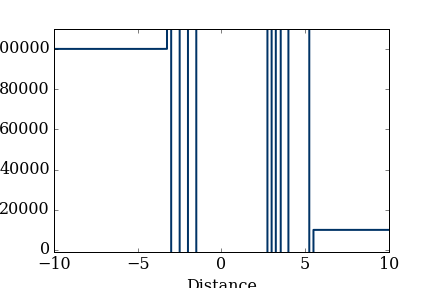
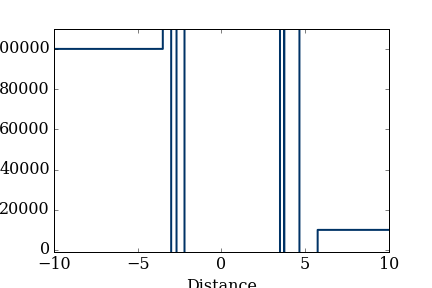
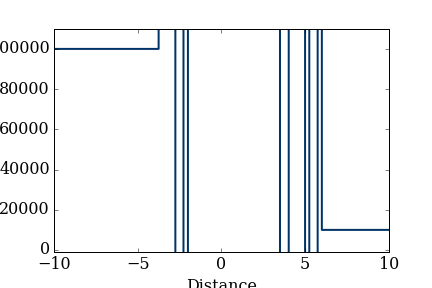
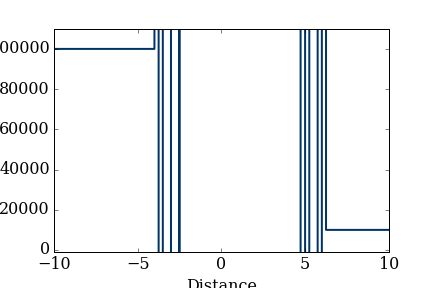

In [197]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=((x_L,x_R)),ylim=(-1000,110000),xlabel=('Distance'),ylabel=('Gas pressure'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(x_L,x_R,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=pressure, interval=50)
display_animation(anim, default_mode='once')

#### Energy


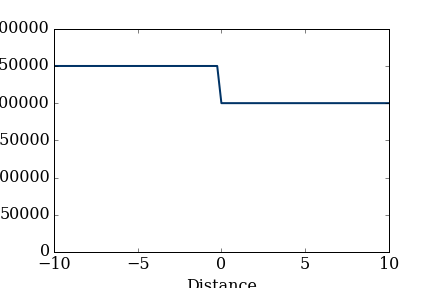
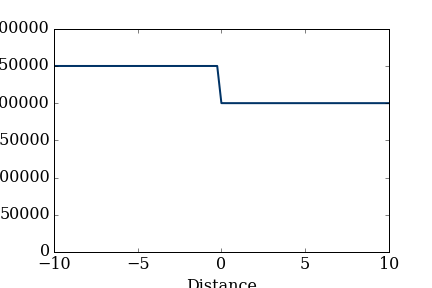
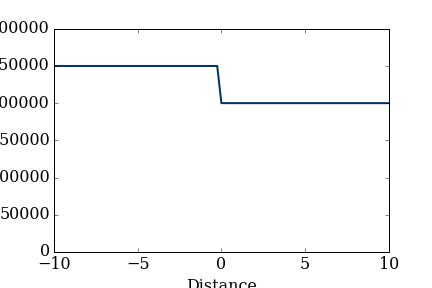
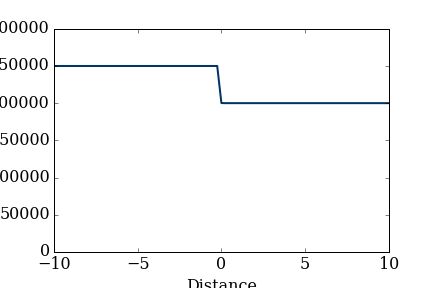
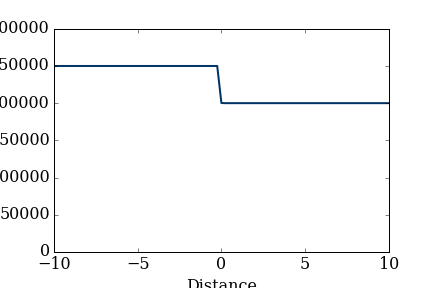
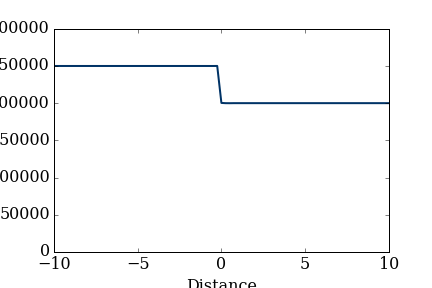
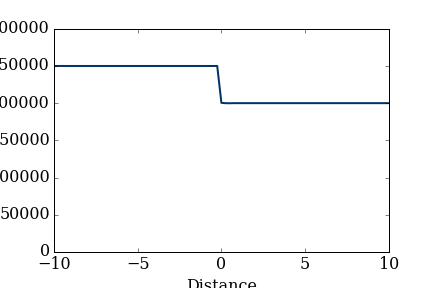
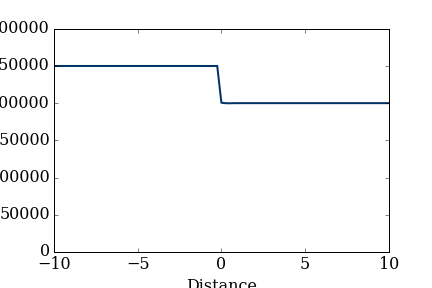
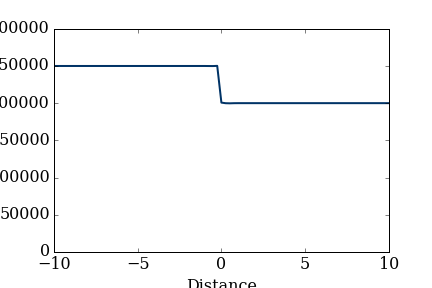
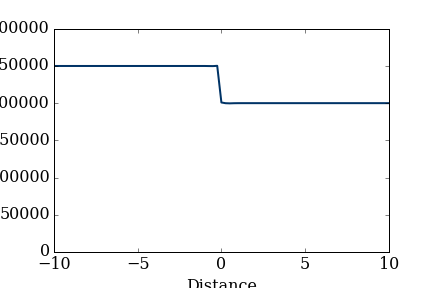
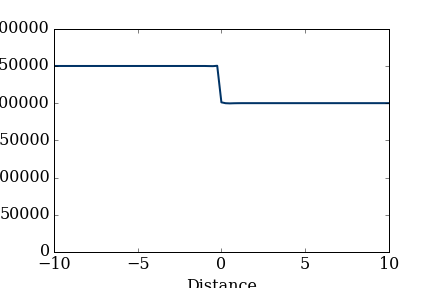
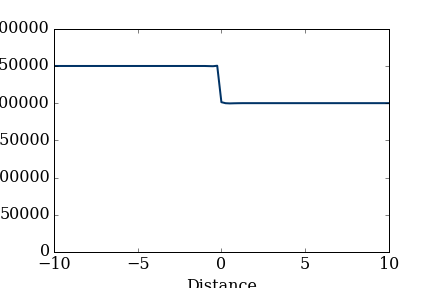
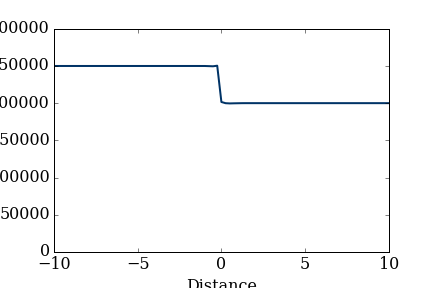
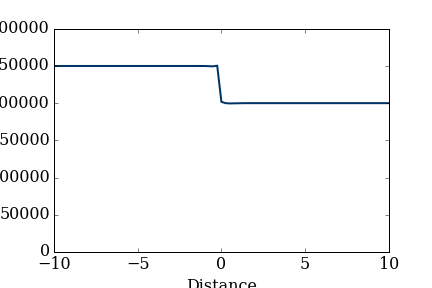
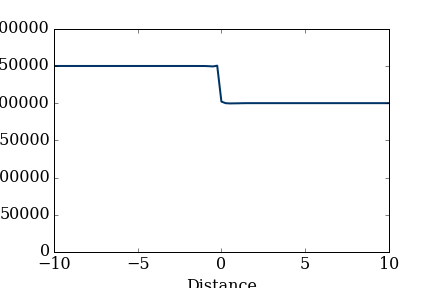
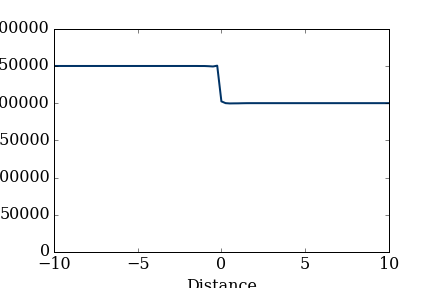
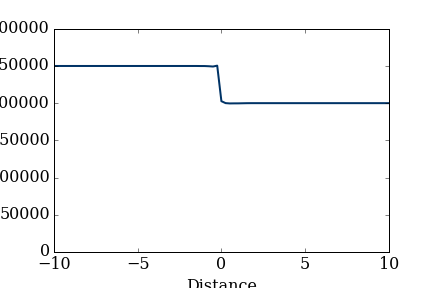
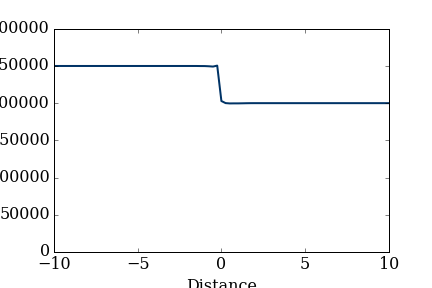
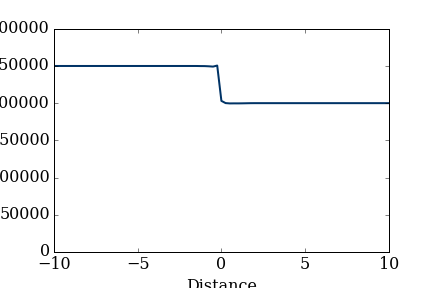
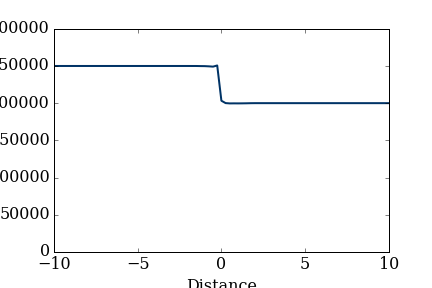
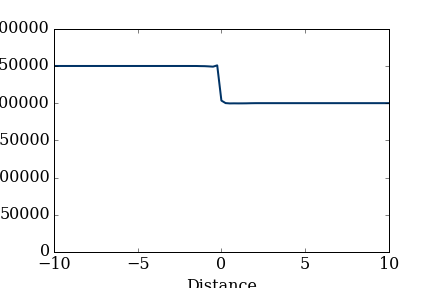
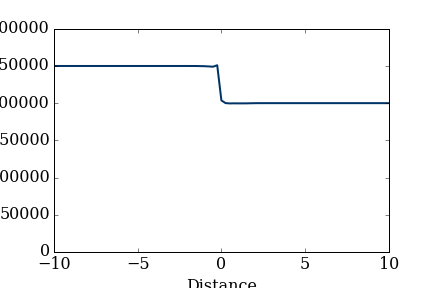
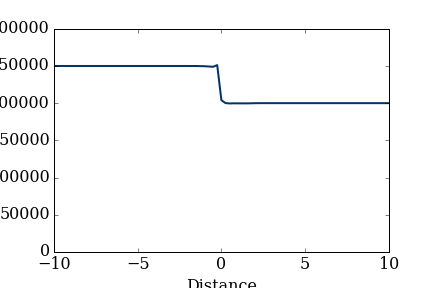
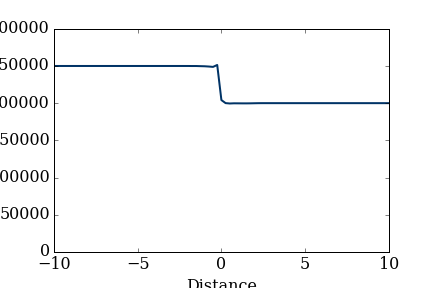
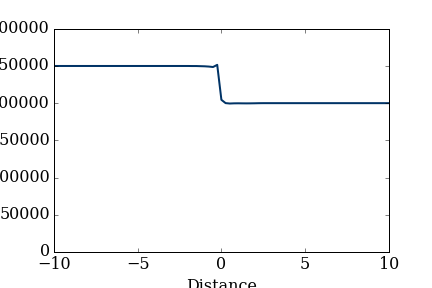
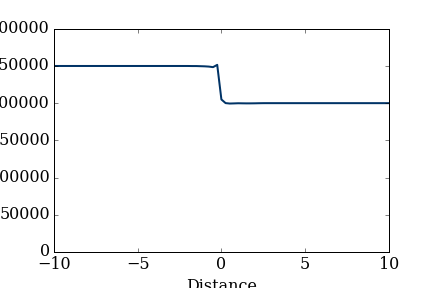
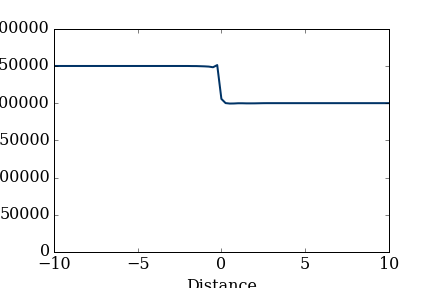
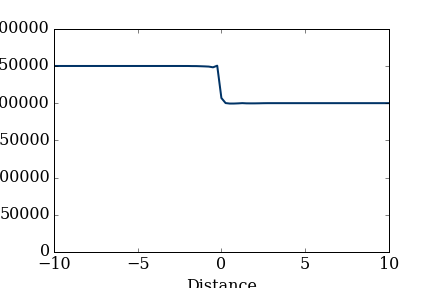
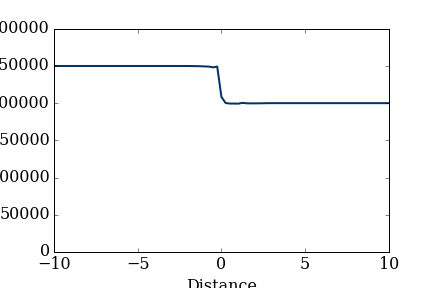
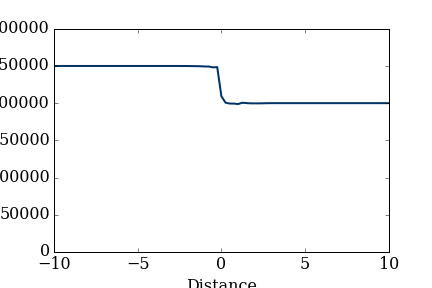
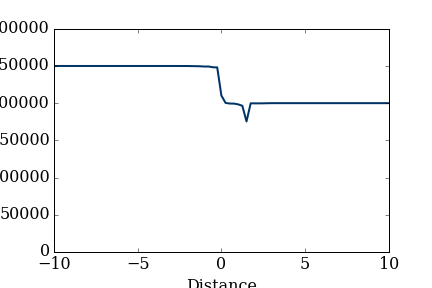
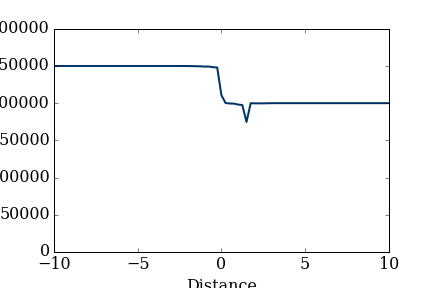
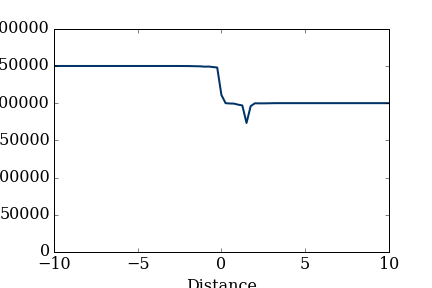
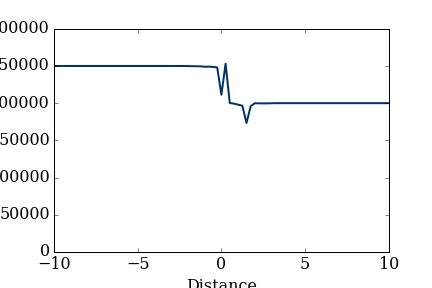
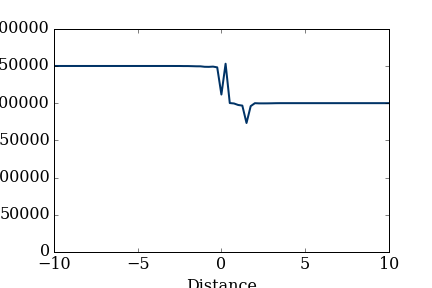
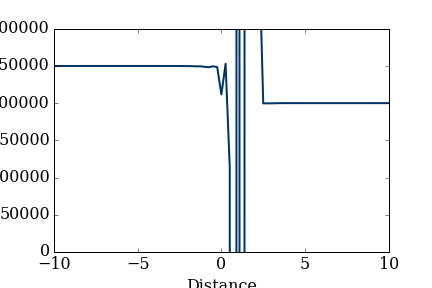
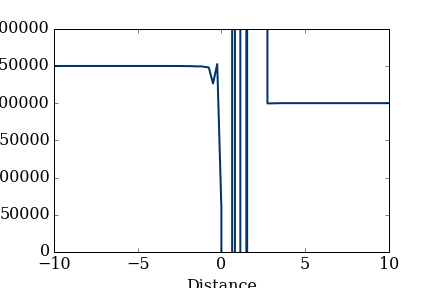
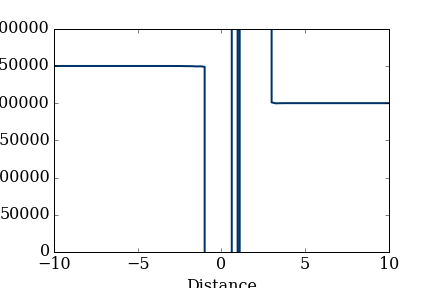
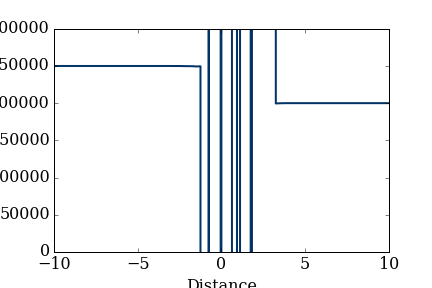
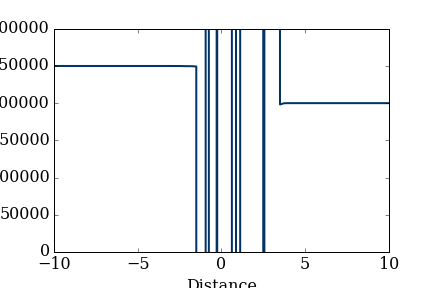
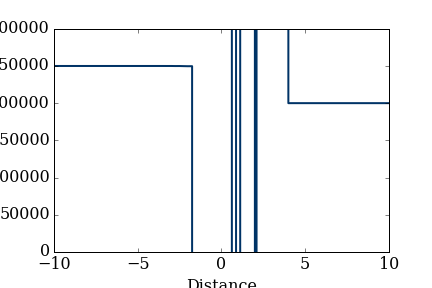
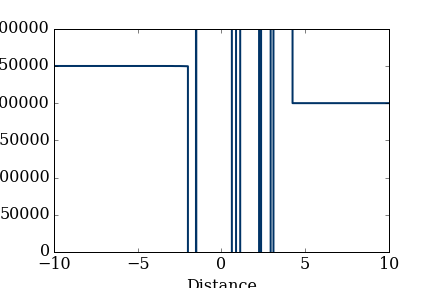
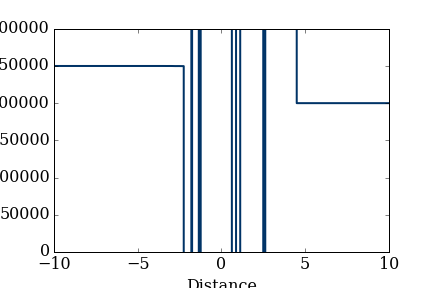
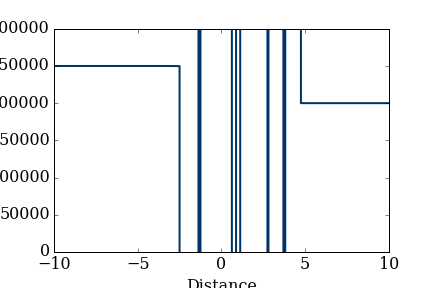
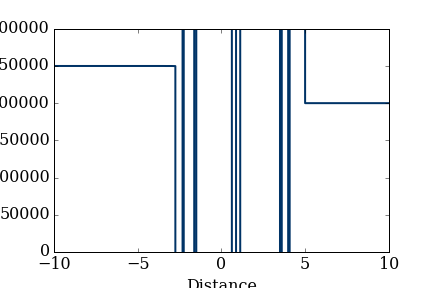
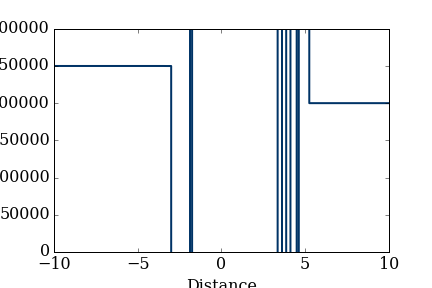
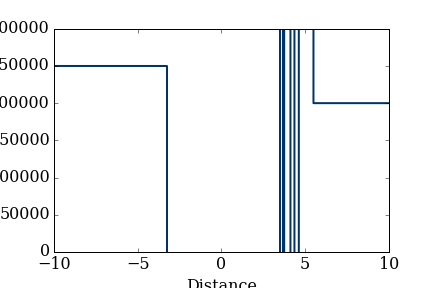
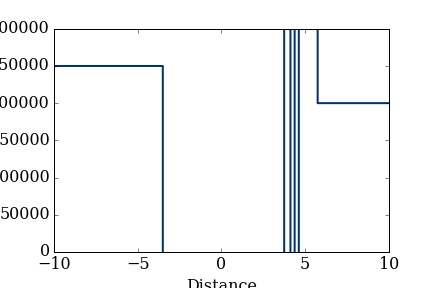
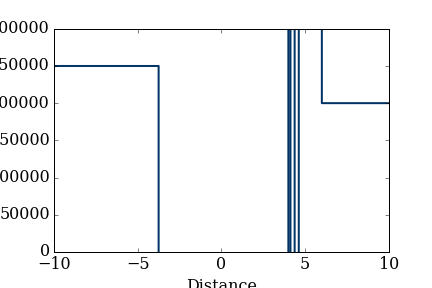
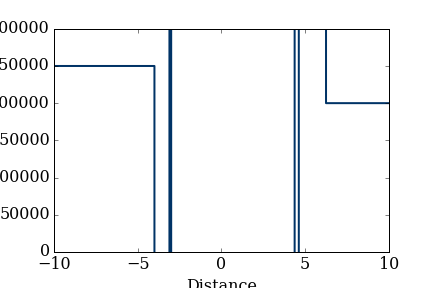

In [198]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=((x_L,x_R)),ylim=(-200, 300000),xlabel=('Distance'),ylabel=('Gas energy'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(x_L,x_R,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=energy, interval=50)
display_animation(anim, default_mode='once')